For this analysis we will only be looking at Female participants. This will furhter be subgrouped by ethnicity. Because we are looking at differences in Autism Screening questionnaire responses we will only be using _Score variables as predictors. 

In [1]:
# Import libraries
%matplotlib inline

from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

!pip install mord
from mord import LogisticIT

!pip install scikit-plot
import scikitplot as skplt
!pip install dmba
from dmba import plotDecisionTree, classificationSummary, regressionSummary, liftChart, gainsChart, adjusted_r2_score, exhaustive_search, backward_elimination, forward_selection, AIC_score, BIC_score
from dmba.metric import AIC_score

import heapq
from collections import defaultdict
from mlxtend.frequent_patterns import apriori, association_rules

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
no display found. Using non-interactive Agg backend


In [2]:
# Upload autism dataset
autism_df = pd.read_csv('autism_df.csv')
autism_df.shape

(703, 21)

In [3]:
# Create a Female-only dataset from the autism dataset.
female_df = autism_df[(autism_df['gender']=='f')]
female_df.shape

(336, 21)

In [4]:
# Split the dataset with Class/ASD as the target variable and _Score variables as predictors.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= female_df[predictors]
y= female_df[outcome]
# Convert categorical vairables to dummies.
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [5]:
# Run a maximal tree
fullClassTree = DecisionTreeClassifier(random_state=1)
fullClassTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [6]:
# Check model accuracy
classificationSummary(train_Y,fullClassTree.predict(train_X))
classificationSummary(valid_Y,fullClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual   0   1
     0 142   0
     1   0  59
Confusion Matrix (Accuracy 0.9185)

       Prediction
Actual  0  1
     0 85  6
     1  5 39


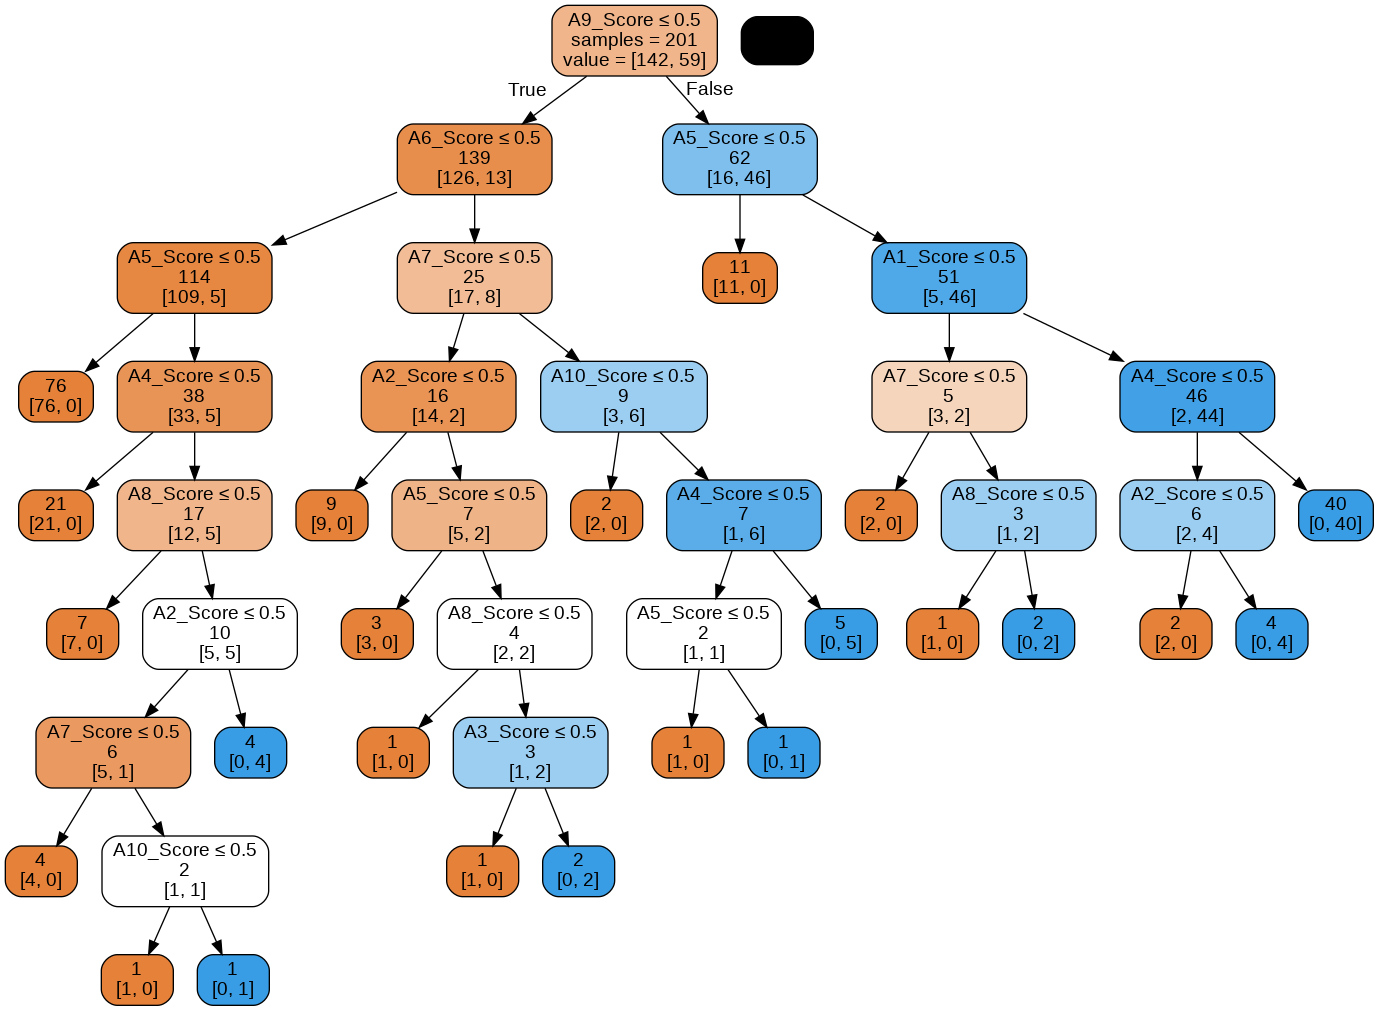

In [7]:
# Plot the tree
plotDecisionTree(fullClassTree, feature_names=train_X.columns)

NOTE: Several permutations of parameters were tested when conducting gridsearches in this analysis

In [8]:
# Create parameters to optimize the tree
param_grid = {
    'max_depth':[2, 3, 5, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [9]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [10]:
# Check for the best parameters
gridsearch.best_params_

{'max_depth': 2, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

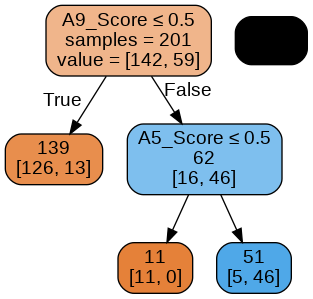

In [11]:
# Run the optimized tree and plot.
gridClassTree = DecisionTreeClassifier(max_depth=2, 
                                       min_impurity_decrease=0.02, 
                                       min_samples_split=0.07,
                                       random_state=1)
gridClassTree.fit(train_X, train_Y)
plotDecisionTree(gridClassTree, feature_names = train_X.columns)

In [12]:
# Check model accuracy
classificationSummary(train_Y, gridClassTree.predict(train_X))
classificationSummary(valid_Y, gridClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9104)

       Prediction
Actual   0   1
     0 137   5
     1  13  46
Confusion Matrix (Accuracy 0.8519)

       Prediction
Actual  0  1
     0 83  8
     1 12 32


In [13]:
# Create variable for model prediction
pred_tree = gridClassTree.predict(valid_X)

In [14]:
# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_tree)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives", tp)
print("Total number of false negatives",fn)
print("Total number of false positives",fp)
print("Total number of true negatives",tn)


Total number of true positives 32
Total number of false negatives 12
Total number of false positives 8
Total number of true negatives 83


In [15]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [16]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [17]:
# Check for best variables
gridsearch.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.01,
 'n_estimators': 200}

In [18]:
# Run a random forest
randomForest = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=6, min_impurity_decrease=0.001, min_samples_split=0.01)
randomForest.fit(train_X, train_Y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.001,
                       min_samples_split=0.01, n_estimators=200,
                       random_state=1)

In [19]:
# Calculate feature importance and standard deviation
importance = randomForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in randomForest.estimators_], axis=0)

In [20]:
# Check feature importance and standard deviation
randomForest_df = pd.DataFrame({'feature': train_X.columns,
                   'importance': importance,
                   'std': std})
print(randomForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.275067  0.193068
4   A5_Score    0.202490  0.139482
5   A6_Score    0.128100  0.139457
3   A4_Score    0.104006  0.100614
9  A10_Score    0.066508  0.078986
0   A1_Score    0.057989  0.048592
2   A3_Score    0.046824  0.062337
1   A2_Score    0.043036  0.038498
7   A8_Score    0.041818  0.043289
6   A7_Score    0.034162  0.035681


Text(0.5, 1.0, 'Visualizing Important Features')

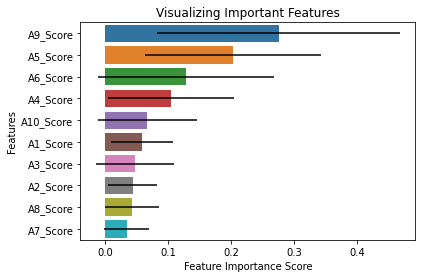

In [21]:
# Plot feature importance
value_plot = randomForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [22]:
# Check model accuarcy
classificationSummary(train_Y, randomForest.predict(train_X))
classificationSummary(valid_Y, randomForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9950)

       Prediction
Actual   0   1
     0 142   0
     1   1  58
Confusion Matrix (Accuracy 0.9407)

       Prediction
Actual  0  1
     0 87  4
     1  4 40


In [23]:
pred_forest = randomForest.predict(valid_X)
cm = confusion_matrix(valid_Y, pred_forest)
tn = cm[0][0]
#fp = cm[0][1]
#fn = cm[1][0]
#tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 32
Total number of false negatives: 12
Total number of false positives: 8
Total number of true negatives: 87


In [24]:
print(classification_report(valid_Y, randomForest.predict(valid_X)))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        91
           1       0.91      0.91      0.91        44

    accuracy                           0.94       135
   macro avg       0.93      0.93      0.93       135
weighted avg       0.94      0.94      0.94       135



In [25]:
# Run a linear regression
lin_reg = LinearRegression()
lin_reg.fit(train_X, train_Y)

LinearRegression()

In [26]:
# Check variable coefficients and odds ratio
result = pd.DataFrame({'coef': lin_reg.coef_[0], 'odds': np.e**lin_reg.coef_[0]}, index=X.columns)
print(result.sort_values('odds', ascending = False))

               coef      odds
A9_Score   0.291164  1.337984
A5_Score   0.215946  1.241035
A6_Score   0.192067  1.211752
A1_Score   0.155278  1.167983
A2_Score   0.134880  1.144399
A4_Score   0.130804  1.139744
A8_Score   0.126643  1.135012
A3_Score   0.098933  1.103992
A7_Score   0.069852  1.072350
A10_Score  0.059643  1.061457


In [27]:
# Check model accuracy
regressionSummary(train_Y, lin_reg.predict(train_X))
regressionSummary(valid_Y, lin_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.2354
     Mean Absolute Error (MAE) : 0.1899

Regression statistics

               Mean Error (ME) : -0.0053
Root Mean Squared Error (RMSE) : 0.2604
     Mean Absolute Error (MAE) : 0.1990


In [28]:
# Install shap for visualization
!pip install shap
import shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

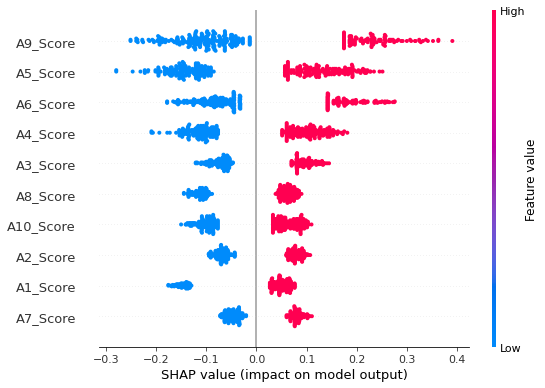

In [29]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(lin_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [30]:
# Run a logistic regression with C=1
log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [31]:
# Check model accuracy
classificationSummary(train_Y, log_reg.predict(train_X))
classificationSummary(valid_Y, log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9602)

       Prediction
Actual   0   1
     0 139   3
     1   5  54
Confusion Matrix (Accuracy 0.9333)

       Prediction
Actual  0  1
     0 84  7
     1  2 42


In [32]:
# Create a variable for model predictions
pred_log = log_reg.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_log)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 42
Total number of false negatives: 2
Total number of false positives: 7
Total number of true negatives: 84


In [33]:
# Check variable coefficients and odds ratio
log_result = pd.DataFrame({'coef': log_reg.coef_[0], 'odds': np.e**log_reg.coef_[0]}, index=X.columns)
print(log_result.sort_values('coef', ascending=False))

               coef      odds
A9_Score   1.533162  4.632801
A5_Score   1.355721  3.879556
A6_Score   1.133214  3.105622
A4_Score   0.835397  2.305730
A3_Score   0.645770  1.907454
A1_Score   0.605536  1.832235
A2_Score   0.589131  1.802421
A8_Score   0.511200  1.667291
A10_Score  0.495990  1.642124
A7_Score   0.458409  1.581555


In [34]:
# Create optional hidden layers for neural network
clf_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [35]:
# Run a grid search to find the best number of hidden layers
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=clf_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [36]:
# Find the best hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 7}

In [37]:
# Run a neural network with 7 hidden layers
clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=7, random_state=1)
clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=7, random_state=1,
              solver='lbfgs')

In [38]:
# Check model accuracy
classificationSummary(valid_Y, clf.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual  0  1
     0 91  0
     1  0 44


In [39]:
# Create a variable for model predictions
pred_network = clf.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_network)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 44
Total number of false negatives: 0
Total number of false positives: 0
Total number of true negatives: 91


In [40]:
pred = clf.predict_proba(valid_X)

<Figure size 720x720 with 0 Axes>

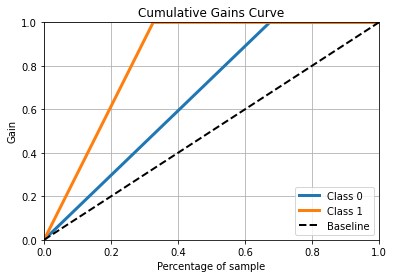

In [41]:
# Run a cumulative gains chart
import scikitplot as skplt
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, pred)
plt.show()

In [42]:
# Create dataset using _Score variables and ID
scores_df = female_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
scores_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,ID
0,1,1,1,1,0,0,1,1,0,0,0
3,1,1,0,1,0,0,1,1,0,1,3
4,1,0,0,0,0,0,0,1,0,0,4
6,0,1,0,0,0,0,0,1,0,0,6
11,0,1,0,1,1,1,1,0,0,1,11


In [43]:
# Set ID as index
scores_df.set_index('ID', inplace=True)
scores_df.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
0,1,1,1,1,0,0,1,1,0,0
3,1,1,0,1,0,0,1,1,0,1
4,1,0,0,0,0,0,0,1,0,0
6,0,1,0,0,0,0,0,1,0,0
11,0,1,0,1,1,1,1,0,0,1


In [44]:
# Check itemset frequency with a minimum of 15% support using apriori
questionsets = apriori(scores_df, min_support=.25, use_colnames=True)
questionsets.head()

,support,itemsets
0,0.755952,(A1_Score)
1,0.479167,(A2_Score)
2,0.458333,(A3_Score)
3,0.526786,(A4_Score)
4,0.520833,(A5_Score)


In [45]:
# Use association rules to check relations between _Scores. Use minimum 50% confidence as metric.
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5)
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
100,"(A3_Score, A5_Score)",(A4_Score),0.303571,0.526786,0.267857,0.882353,1.674975,0.107940,4.022321
103,(A4_Score),"(A3_Score, A5_Score)",0.526786,0.303571,0.267857,0.508475,1.674975,0.107940,1.416872
43,(A9_Score),(A5_Score),0.321429,0.520833,0.270833,0.842593,1.617778,0.103423,3.044118
42,(A5_Score),(A9_Score),0.520833,0.321429,0.270833,0.520000,1.617778,0.103423,1.413690
106,"(A3_Score, A10_Score)",(A4_Score),0.312500,0.526786,0.261905,0.838095,1.590960,0.097284,2.922794


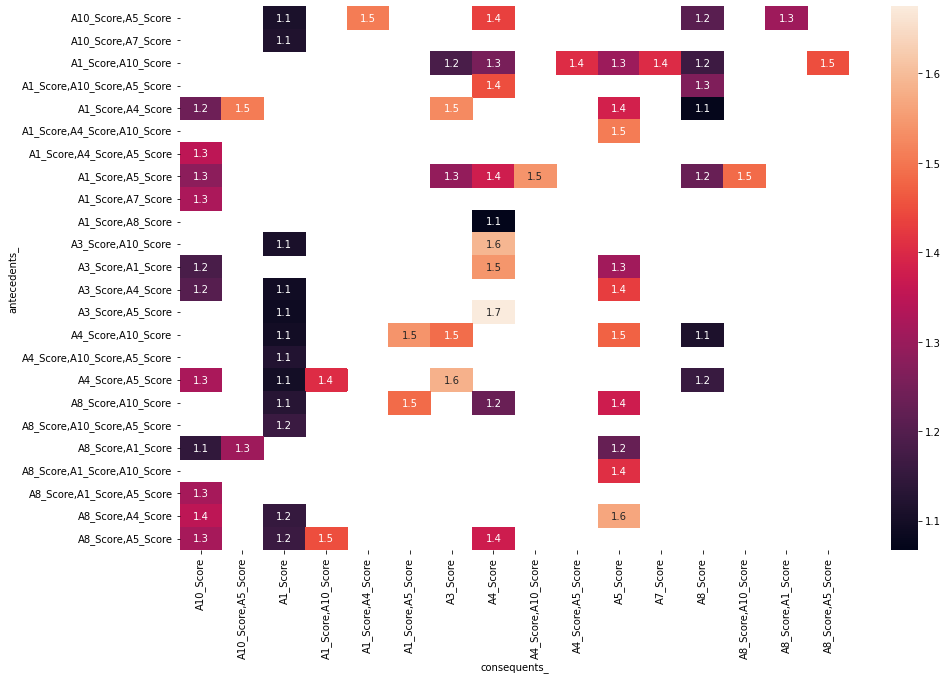

In [46]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [47]:
# Change value 'White-European' to 'White'
female_df['ethnicity'] = female_df['ethnicity'].replace(['White-European'], 'White')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
# Create a dataset for White females
white_df = female_df[(female_df['ethnicity']=='White')]
white_df.shape

(124, 21)

In [49]:
# Split the dataset
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= white_df[predictors]
y= white_df[outcome]
# Replace categorical variables with dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [50]:
# Run a maximal tree
whiteFullTree = DecisionTreeClassifier(random_state=1)
whiteFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [51]:
# Check model accuracy
classificationSummary(valid_Y, whiteFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8800)

       Prediction
Actual  0  1
     0 22  3
     1  3 22


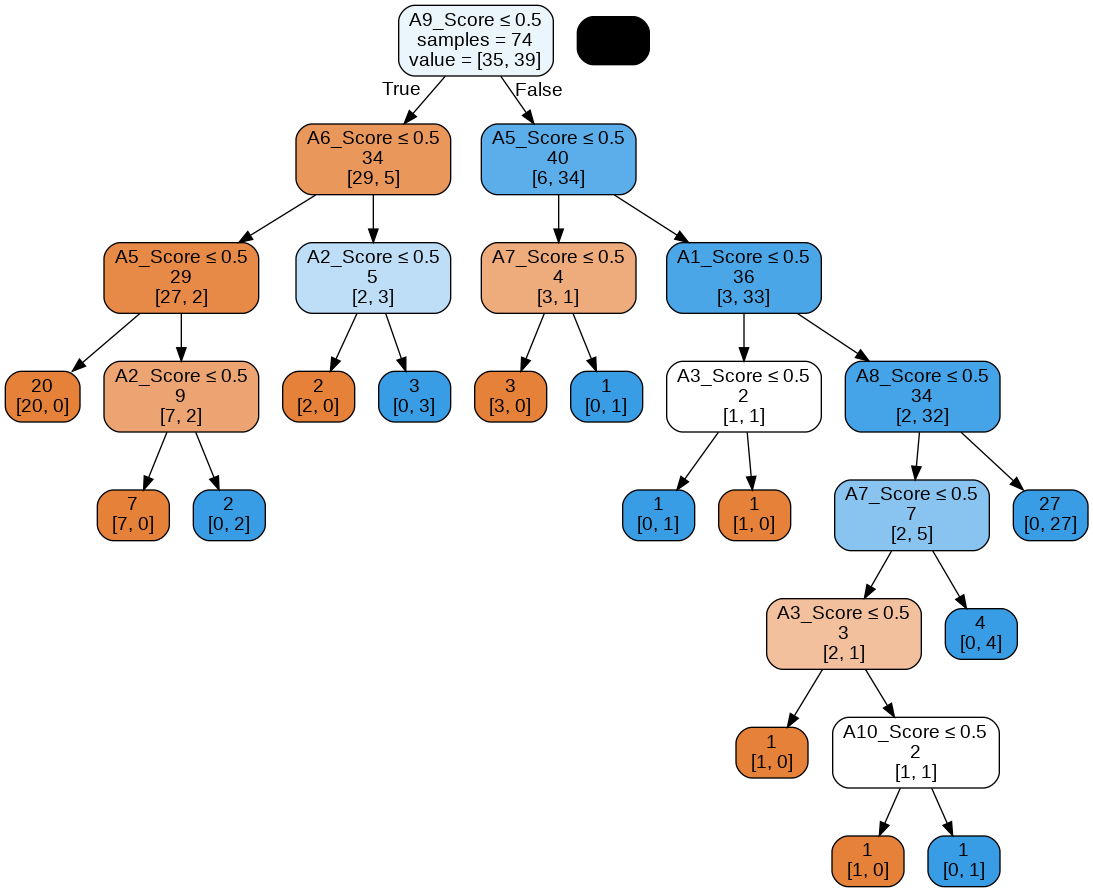

In [52]:
# Plot the tree
plotDecisionTree(whiteFullTree, feature_names=train_X.columns)

In [53]:
# Set parameters to optimize the tree
param_grid = {
    'max_depth':[3, 5, 7, 8, 9],
    'min_samples_split': [0.05, 0.01, 0.005, 0.001, 0.0001],
    'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001, 0.005]
} 

In [54]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 8, 9],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001,
                                                   0.005],
                         'min_samples_split': [0.05, 0.01, 0.005, 0.001,
                                               0.0001]})

In [55]:
# Check for the best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.05, 'min_samples_split': 0.05}

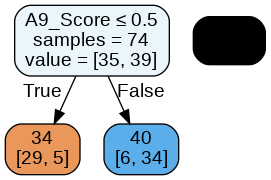

In [56]:
# Run the optimized tree and plot
whiteClassTree = DecisionTreeClassifier(max_depth=3, 
                                        min_impurity_decrease=0.05, 
                                        min_samples_split=0.05,
                                        random_state=1)
whiteClassTree.fit(train_X, train_Y)
plotDecisionTree(whiteClassTree, feature_names = train_X.columns)

In [57]:
# Check model accuracy
classificationSummary(valid_Y, whiteClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8400)

       Prediction
Actual  0  1
     0 24  1
     1  7 18


In [58]:
# Create a variable for model predictions
pred_whitetree = whiteClassTree.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_whitetree)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 18
Total number of false negatives: 7
Total number of false positives: 1
Total number of true negatives: 24


In [59]:
# Set random forest parameters 
param_grid = {
    'max_depth':[5, 6, 7, 8],
    'min_samples_split': [0.05, 0.02, 0.01],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [60]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.02, 0.01],
                         'n_estimators': [100, 200, 300]})

In [61]:
# Check best parameters
gridsearch.best_params_

{'max_depth': 5,
 'min_impurity_decrease': 0.001,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [62]:
# Run a random forest
whiteForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=5, min_impurity_decrease=0.001, min_samples_split=0.05)
whiteForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=5, min_impurity_decrease=0.001,
                       min_samples_split=0.05, random_state=1)

In [63]:
# Check feature importance and standard deviation
importance = whiteForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in whiteForest.estimators_], axis=0)

whiteForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(whiteForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.281884  0.236822
4   A5_Score    0.218816  0.214353
5   A6_Score    0.182414  0.205197
1   A2_Score    0.076252  0.080108
7   A8_Score    0.052216  0.079046
3   A4_Score    0.046456  0.077251
9  A10_Score    0.040788  0.071473
2   A3_Score    0.037924  0.085968
0   A1_Score    0.036691  0.057224
6   A7_Score    0.026558  0.043371


Text(0.5, 1.0, 'Visualizing Important Features')

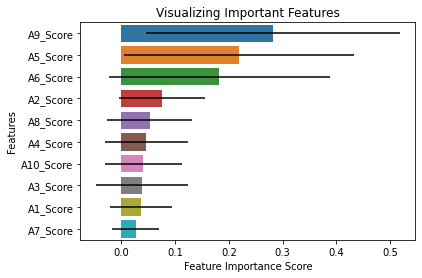

In [64]:
# Plot feature importance
value_plot = whiteForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [65]:
# Check model accuracy
classificationSummary(valid_Y, whiteForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9200)

       Prediction
Actual  0  1
     0 22  3
     1  1 24


In [66]:
# Create optional hidden layer sizes for neural network
whiteCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [67]:
# Run a grid search to find optimal hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=whiteCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [68]:
# Check for best parameters
gridsearch.best_params_

{'hidden_layer_sizes': 4}

In [69]:
# Run a neural network with 4 hidden layers
white_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=4, random_state=1)
white_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=4, random_state=1,
              solver='lbfgs')

In [70]:
# Check model accuracy
classificationSummary(valid_Y, white_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9200)

       Prediction
Actual  0  1
     0 21  4
     1  0 25


In [71]:
# Create a variable for model prediction probabilites
white_clf_pred = white_clf.predict_proba(valid_X)

<Figure size 720x720 with 0 Axes>

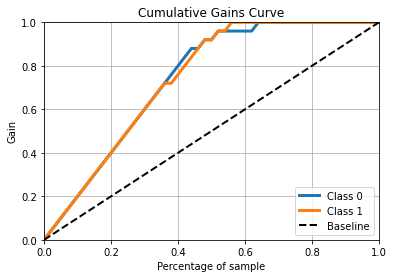

In [72]:
# Plot a cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, white_clf_pred)
plt.show()

In [73]:
# Run a Linear Regression
white_reg = LinearRegression()
white_reg.fit(train_X, train_Y)

LinearRegression()

In [74]:
# Check model accuracy
regressionSummary(valid_Y, white_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : 0.0301
Root Mean Squared Error (RMSE) : 0.2849
     Mean Absolute Error (MAE) : 0.2271


In [75]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': white_reg.coef_[0], 'odds': np.e**white_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.141135  1.151580
A2_Score   0.216305  1.241481
A3_Score  -0.012408  0.987669
A4_Score   0.211509  1.235541
A5_Score   0.290809  1.337509
A6_Score   0.237357  1.267894
A7_Score   0.103267  1.108787
A8_Score   0.047316  1.048454
A9_Score   0.292747  1.340104
A10_Score  0.186127  1.204575


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

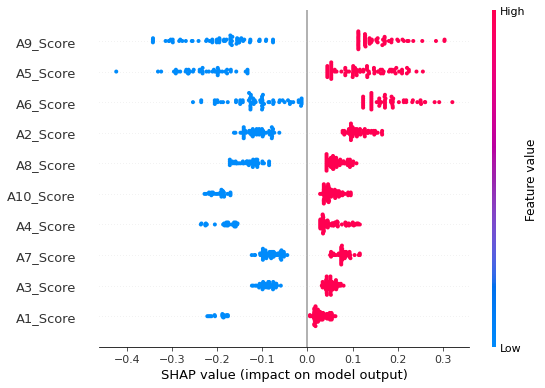

In [76]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(white_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [77]:
# Run a logistic regression
white_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
white_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [78]:
# Check model accuracy
classificationSummary(valid_Y, white_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9200)

       Prediction
Actual  0  1
     0 21  4
     1  0 25


In [79]:
# Create a variable for model accuracy
pred_whitelog = white_log_reg.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_whitelog)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 25
Total number of false negatives: 0
Total number of false positives: 4
Total number of true negatives: 21


In [80]:
# Check variable coefficients and odds ratio
white_result = pd.DataFrame({'coef': white_log_reg.coef_[0], 'odds': np.e**white_log_reg.coef_[0]}, index=X.columns)
print(white_result.sort_values('coef', ascending=False))

               coef      odds
A9_Score   1.371763  3.942294
A6_Score   1.330846  3.784242
A5_Score   1.199204  3.317477
A2_Score   0.858799  2.360325
A8_Score   0.402007  1.494822
A7_Score   0.375811  1.456172
A10_Score  0.278772  1.321507
A4_Score   0.189611  1.208779
A3_Score   0.091208  1.095497
A1_Score  -0.294455  0.744937


In [81]:
# Create a dataset with _Score variables and ID. 
white_scores = white_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
# Set ID as index
white_scores.set_index('ID', inplace=True)
white_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
0,1,1,1,1,0,0,1,1,0,0
3,1,1,0,1,0,0,1,1,0,1
31,1,0,0,1,1,1,1,1,0,1
33,1,1,1,1,1,1,1,1,1,1
34,1,1,1,1,1,1,1,1,1,1


In [82]:
# Check for frequent itemsets with 20% minimum support using aprior
questionsets = apriori(white_scores, min_support=.2, use_colnames=True)
questionsets.head()

,support,itemsets
0,0.862903,(A1_Score)
1,0.548387,(A2_Score)
2,0.612903,(A3_Score)
3,0.741935,(A4_Score)
4,0.645161,(A5_Score)


In [83]:
# Check for relations between _Score variables using associatio rules. Use minimum 50% confidence as metric.
white_rules = association_rules(questionsets, metric='confidence', min_threshold=0.5)
white_rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
6829,"(A7_Score, A9_Score)","(A1_Score, A4_Score, A6_Score, A10_Score)",0.266129,0.330645,0.201613,0.757576,2.291205,0.113619,2.761089
6802,"(A1_Score, A4_Score, A6_Score, A10_Score)","(A7_Score, A9_Score)",0.330645,0.266129,0.201613,0.609756,2.291205,0.113619,1.880544
7126,"(A4_Score, A6_Score, A10_Score)","(A3_Score, A5_Score, A7_Score)",0.354839,0.250000,0.201613,0.568182,2.272727,0.112903,1.736842
7119,"(A3_Score, A5_Score, A7_Score)","(A4_Score, A6_Score, A10_Score)",0.250000,0.354839,0.201613,0.806452,2.272727,0.112903,3.333333
7036,"(A3_Score, A5_Score, A10_Score)","(A2_Score, A4_Score, A6_Score)",0.387097,0.241935,0.209677,0.541667,2.238889,0.116025,1.653959


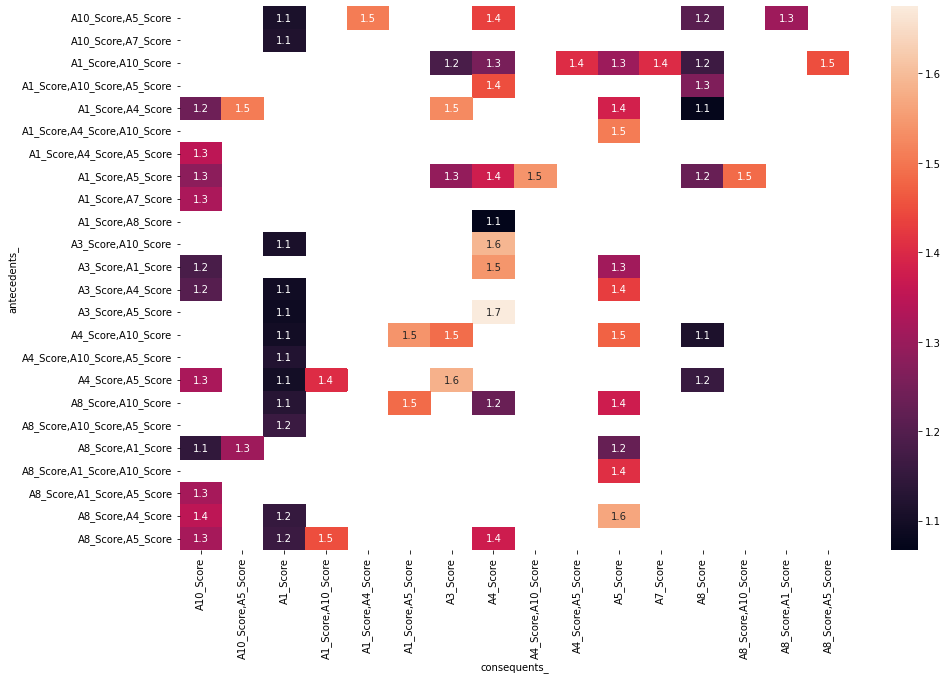

In [84]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [85]:
#Create dataset for Black females
black_df = female_df[(female_df['ethnicity']=='Black')]
black_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
6,6,0,1,0,0,0,0,0,1,0,...,17,f,Black,no,no,United States,no,2,Self,NO
21,21,0,0,0,0,0,0,0,0,0,...,27,f,Black,no,no,United Arab Emirates,no,0,Self,NO
51,51,1,1,1,1,1,1,1,1,1,...,35,f,Black,no,no,France,no,10,Parent,YES
76,76,1,1,0,1,1,1,1,1,1,...,33,f,Black,no,yes,United States,no,8,Self,YES
121,121,1,0,0,0,0,0,0,0,0,...,20,f,Black,no,no,Spain,no,1,Self,NO


In [86]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= black_df[predictors]
y= black_df[outcome]
# convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [87]:
# Create a maximal tree
blackFullTree = DecisionTreeClassifier(random_state=1)
blackFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [88]:
# Check accuracy
classificationSummary(valid_Y, blackFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7000)

       Prediction
Actual 0 1
     0 4 2
     1 1 3


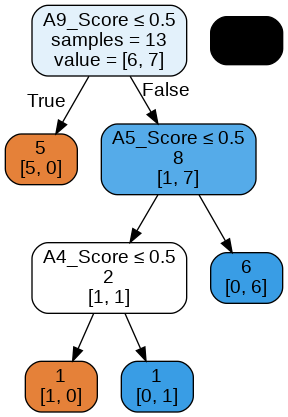

In [89]:
# Plot the tree
plotDecisionTree(blackFullTree, feature_names=train_X.columns)

In [90]:
# Set parameters for decision tree
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [91]:
# Run a grid search for best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [92]:
# Check for the best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

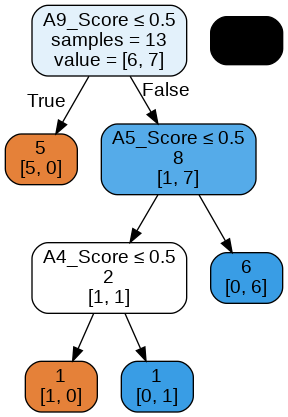

In [93]:
# Plot optimized tree
blackClassTree = DecisionTreeClassifier(max_depth=7, 
                                        min_impurity_decrease=0.001, 
                                        min_samples_split=0.01,
                                        random_state=1)
blackClassTree.fit(train_X, train_Y)
plotDecisionTree(blackClassTree, feature_names = train_X.columns)

In [94]:
# Check accuracy
classificationSummary(valid_Y, blackClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.7000)

       Prediction
Actual 0 1
     0 4 2
     1 1 3


In [95]:
# Create a variable for model predictions
pred_blacktree = blackClassTree.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_blacktree)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 3
Total number of false negatives: 1
Total number of false positives: 2
Total number of true negatives: 4


In [96]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [97]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [98]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 300}

In [99]:
# Run a random forest
blackForest = RandomForestClassifier(random_state=1, n_estimators=300, max_depth=3, min_impurity_decrease=0.01, min_samples_split=0.05)
blackForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.01,
                       min_samples_split=0.05, n_estimators=300,
                       random_state=1)

In [100]:
# Check importance and standard deviation for features
importance = blackForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in blackForest.estimators_], axis=0)

blackForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(blackForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.271758  0.357815
2   A3_Score    0.176914  0.292845
4   A5_Score    0.152766  0.258560
5   A6_Score    0.102678  0.215260
1   A2_Score    0.098706  0.202712
3   A4_Score    0.090564  0.178296
6   A7_Score    0.039104  0.093972
9  A10_Score    0.038944  0.124698
7   A8_Score    0.016473  0.072279
0   A1_Score    0.012094  0.059218


Text(0.5, 1.0, 'Visualizing Important Features')

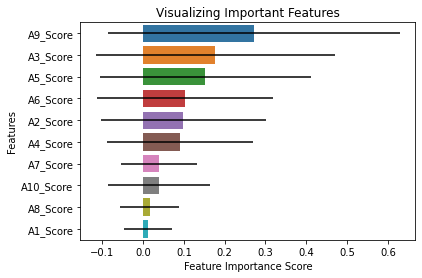

In [101]:
# Plot feature importance
value_plot = blackForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [102]:
# Check accuracy
classificationSummary(valid_Y, blackForest.predict(valid_X))

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual 0 1
     0 4 2
     1 0 4


In [103]:
# Create optional hidden layer sizes for neural network
blackCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [104]:
# Run a grid search to find optimal hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=blackCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [105]:
# Find best layer size
gridsearch.best_params_

{'hidden_layer_sizes': 2}

In [106]:
# Run a neural network with 2 hidden layers
black_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=2, random_state=1)
black_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=2, random_state=1,
              solver='lbfgs')

In [107]:
# Check model accuracy
classificationSummary(valid_Y, black_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual 0 1
     0 4 2
     1 0 4


<Figure size 720x720 with 0 Axes>

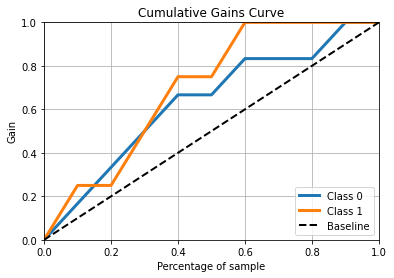

In [108]:
# Create a variable for model prediction probabilities
black_clf_pred = black_clf.predict_proba(valid_X)

# Plot cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, black_clf_pred)
plt.show()

In [109]:
# Run a linear regression
black_reg = LinearRegression()
black_reg.fit(train_X, train_Y)

LinearRegression()

In [110]:
# Check variable coefficients and odds ratios
print(pd.DataFrame({'coef': black_reg.coef_[0], 'odds': np.e**black_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.091935  0.912164
A2_Score   0.139355  1.149532
A3_Score   0.173548  1.189518
A4_Score   0.227419  1.255356
A5_Score   0.233871  1.263481
A6_Score   0.117742  1.124954
A7_Score  -0.057097  0.944503
A8_Score  -0.065161  0.936916
A9_Score   0.503226  1.654048
A10_Score -0.088065  0.915702


In [111]:
# Check accuracy
regressionSummary(valid_Y, black_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.1629
Root Mean Squared Error (RMSE) : 0.5116
     Mean Absolute Error (MAE) : 0.3395


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

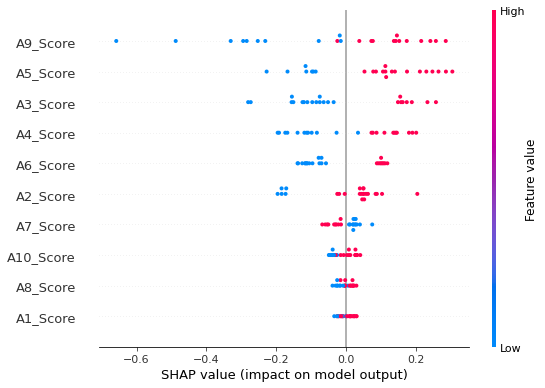

In [112]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(black_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [113]:
# Run a logistic regression
black_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
black_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [114]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': black_log_reg.coef_[0], 'odds': np.e**black_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.255627  0.774430
A2_Score   0.282787  1.326822
A3_Score   0.744271  2.104907
A4_Score   0.496684  1.643263
A5_Score   0.590129  1.804221
A6_Score   0.442558  1.556685
A7_Score  -0.333171  0.716648
A8_Score  -0.170340  0.843378
A9_Score   0.878171  2.406495
A10_Score -0.042026  0.958845


In [115]:
# Check accuracy
classificationSummary(valid_Y, black_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8000)

       Prediction
Actual 0 1
     0 4 2
     1 0 4


In [116]:
# Create a variable for model predictions
pred_blacklog = black_log_reg.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_blacklog)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 4
Total number of false negatives: 0
Total number of false positives: 2
Total number of true negatives: 4


In [117]:
# Create dataset with _Score variables and ID
black_scores = black_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
# Set ID column as index
black_scores.set_index('ID', inplace=True)
black_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
6,0,1,0,0,0,0,0,1,0,0
21,0,0,0,0,0,0,0,0,0,0
51,1,1,1,1,1,1,1,1,1,1
76,1,1,0,1,1,1,1,1,1,0
121,1,0,0,0,0,0,0,0,0,0


In [118]:
# Identify frequent itemsets using apriori
questionsets = apriori(black_scores, min_support=.2, use_colnames=True) # min_support for itemsets is 20%.
questionsets.head()

,support,itemsets
0,0.782609,(A1_Score)
1,0.782609,(A2_Score)
2,0.347826,(A3_Score)
3,0.478261,(A4_Score)
4,0.695652,(A5_Score)


In [119]:
# Check for relationships between _Scores using association rules. Set metric as 'confidence' and min_threshold at 50%.
black_rules = association_rules(questionsets, metric='confidence', min_threshold=0.5)
# Sort values by lift
black_rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2557,"(A1_Score, A2_Score, A4_Score, A10_Score)","(A3_Score, A8_Score)",0.304348,0.217391,0.217391,0.714286,3.285714,0.151229,2.73913
2626,"(A2_Score, A4_Score, A10_Score)","(A3_Score, A1_Score, A9_Score)",0.304348,0.217391,0.217391,0.714286,3.285714,0.151229,2.73913
2521,"(A3_Score, A1_Score, A5_Score)","(A2_Score, A4_Score, A10_Score)",0.217391,0.304348,0.217391,1.000000,3.285714,0.151229,inf
2585,"(A3_Score, A8_Score)","(A1_Score, A2_Score, A4_Score, A10_Score)",0.217391,0.304348,0.217391,1.000000,3.285714,0.151229,inf
2522,"(A2_Score, A4_Score, A10_Score)","(A3_Score, A1_Score, A5_Score)",0.304348,0.217391,0.217391,0.714286,3.285714,0.151229,2.73913


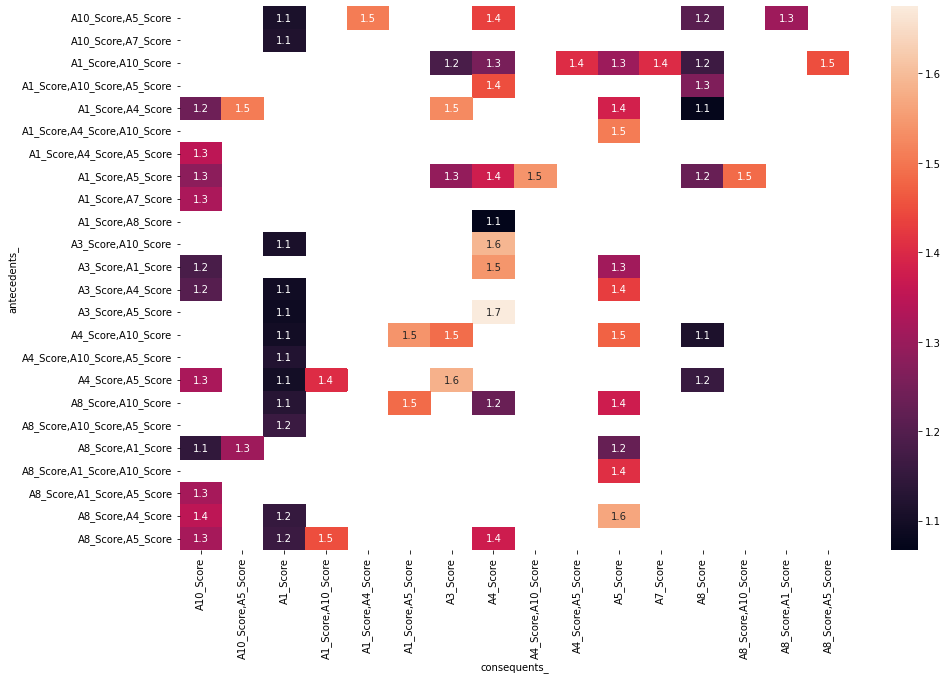

In [120]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [121]:
# Create dataset for Asian ethnicity
asian_df = female_df[(female_df['ethnicity']=='Asian')]
asian_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
41,41,0,0,0,0,1,1,0,0,0,...,28,f,Asian,no,no,Pakistan,no,2,Self,NO
49,49,1,1,0,0,0,1,1,1,0,...,30,f,Asian,no,no,Bangladesh,no,6,Self,NO
54,54,1,1,1,1,1,1,0,1,1,...,30,f,Asian,no,no,China,no,9,Self,YES
100,100,1,0,0,0,0,0,0,1,0,...,39,f,Asian,no,no,Philippines,no,2,Self,NO
107,107,1,0,0,1,1,1,1,0,0,...,19,f,Asian,no,no,India,no,5,Parent,NO


In [122]:
# Split the dataset with Class/ASD as the target variable
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= asian_df[predictors]
y= asian_df[outcome]
# Convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [123]:
# Run a maximal tree
asianFullTree = DecisionTreeClassifier(random_state=1)
asianFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [124]:
# Check accuracy
classificationSummary(valid_Y, asianFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual  0  1
     0 16  2
     1  2  1


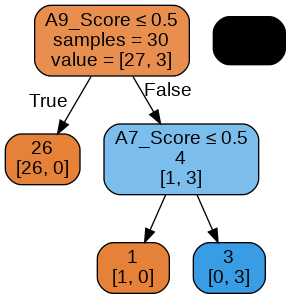

In [125]:
# Plot the decision Tree
plotDecisionTree(asianFullTree, feature_names=train_X.columns)

In [126]:
# Set parameters to optimize the decision tree
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [127]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [128]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

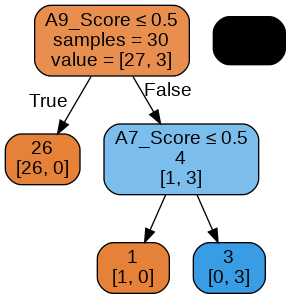

In [129]:
# Run the optimized tree and plot
asianClassTree = DecisionTreeClassifier(max_depth=7, 
                                        min_impurity_decrease=0.001, 
                                        min_samples_split=0.01,
                                        random_state=1)
asianClassTree.fit(train_X, train_Y)
plotDecisionTree(asianClassTree, feature_names = train_X.columns)

In [130]:
# Check accuracy
classificationSummary(valid_Y, asianClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual  0  1
     0 16  2
     1  2  1


In [131]:
# Create a variable for model predictions
pred_asiantree = asianClassTree.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_asiantree)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 1
Total number of false negatives: 2
Total number of false positives: 2
Total number of true negatives: 16


In [132]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [133]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [134]:
# Check the best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [135]:
# Run a random forest
asianForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=3, min_impurity_decrease=0.01, min_samples_split=0.05)
asianForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [136]:
# Check feature importance and standard deviation
importance = asianForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in asianForest.estimators_], axis=0)

asianForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(asianForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.414556  0.393491
2   A3_Score    0.121364  0.212006
3   A4_Score    0.114074  0.217054
5   A6_Score    0.102022  0.179625
1   A2_Score    0.097956  0.176649
7   A8_Score    0.050499  0.137293
0   A1_Score    0.031412  0.108647
9  A10_Score    0.027799  0.086716
6   A7_Score    0.026234  0.081163
4   A5_Score    0.014083  0.056238


Text(0.5, 1.0, 'Visualizing Important Features')

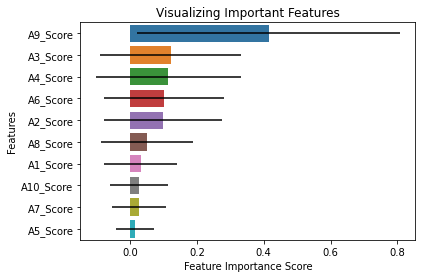

In [137]:
# Plot feature importance
value_plot = asianForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [138]:
# Check accuracy
classificationSummary(valid_Y, asianForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9524)

       Prediction
Actual  0  1
     0 18  0
     1  1  2


In [139]:
# Create optional hidden layer sizes for neural network
asianCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [140]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=asianCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 3 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [141]:
# Check optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 1}

In [142]:
# Run a neural network with 1 hidden layer
asian_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=1, random_state=1)
asian_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=1, random_state=1,
              solver='lbfgs')

In [143]:
# Check model accuracy
classificationSummary(valid_Y, asian_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8571)

       Prediction
Actual  0  1
     0 16  2
     1  1  2


<Figure size 720x720 with 0 Axes>

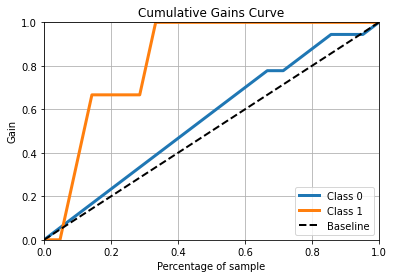

In [144]:
# Create a variable for model prediction probabilites
asian_clf_pred = asian_clf.predict_proba(valid_X)

# Plot the cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, asian_clf_pred)
plt.show()

In [145]:
# Run a linear regression
asian_reg = LinearRegression()
asian_reg.fit(train_X, train_Y)

LinearRegression()

In [146]:
# Check variable coefficients and ods ratio
print(pd.DataFrame({'coef': asian_reg.coef_[0], 'odds': np.e**asian_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.094881  0.909481
A2_Score   0.145138  1.156199
A3_Score   0.056369  1.057988
A4_Score  -0.003636  0.996371
A5_Score   0.073185  1.075929
A6_Score   0.116698  1.123780
A7_Score   0.090231  1.094427
A8_Score   0.138502  1.148552
A9_Score   0.519885  1.681834
A10_Score -0.039144  0.961612


In [147]:
# Check accuracy
regressionSummary(valid_Y, asian_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0349
Root Mean Squared Error (RMSE) : 0.3338
     Mean Absolute Error (MAE) : 0.2227


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

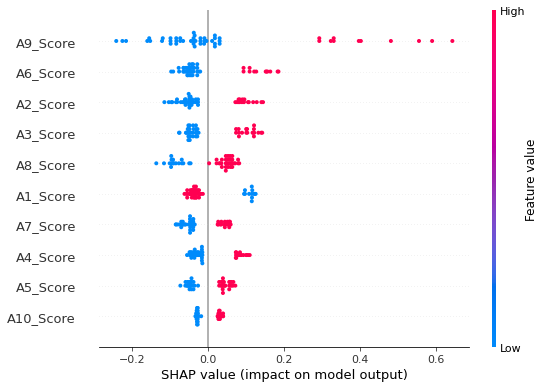

In [148]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(asian_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [149]:
# Run a logistic regression
asian_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
asian_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [150]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': asian_log_reg.coef_[0], 'odds': np.e**asian_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -1.241365  0.288989
A2_Score   0.302150  1.352764
A3_Score   0.431721  1.539905
A4_Score   0.415891  1.515721
A5_Score   0.012819  1.012901
A6_Score   0.504595  1.656314
A7_Score   0.054174  1.055668
A8_Score  -0.149180  0.861414
A9_Score   0.968079  2.632883
A10_Score  0.003966  1.003974


In [151]:
# Check accuracy
classificationSummary(valid_Y, asian_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.8095)

       Prediction
Actual  0  1
     0 17  1
     1  3  0


In [152]:
# Create a variable for model prediction
pred_asianlog = asian_log_reg.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_asianlog)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 0
Total number of false negatives: 3
Total number of false positives: 1
Total number of true negatives: 17


In [153]:
# Create a dataset using _Score variables and ID. Set ID as index.
asian_scores = asian_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
asian_scores.set_index('ID', inplace=True)
asian_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
41,0,0,0,0,1,1,0,0,0,0
49,1,1,0,0,0,1,1,1,0,1
54,1,1,1,1,1,1,0,1,1,1
100,1,0,0,0,0,0,0,1,0,0
107,1,0,0,1,1,1,1,0,0,0


In [154]:
# Check for frequent itemsets using apriori
questionsets = apriori(asian_scores, min_support=.15, use_colnames=True) # Set minimum support to 15%.
questionsets.head()

,support,itemsets
0,0.764706,(A1_Score)
1,0.313725,(A2_Score)
2,0.372549,(A3_Score)
3,0.333333,(A4_Score)
4,0.490196,(A5_Score)


In [155]:
# Check for relations between _Scores using association rules
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with 50% minimum threshold.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
178,"(A2_Score, A5_Score)","(A3_Score, A4_Score)",0.176471,0.215686,0.156863,0.888889,4.121212,0.118800,7.058824
175,"(A3_Score, A4_Score)","(A2_Score, A5_Score)",0.215686,0.176471,0.156863,0.727273,4.121212,0.118800,3.019608
177,"(A2_Score, A4_Score)","(A3_Score, A5_Score)",0.196078,0.235294,0.156863,0.800000,3.400000,0.110727,3.823529
176,"(A3_Score, A5_Score)","(A2_Score, A4_Score)",0.235294,0.196078,0.156863,0.666667,3.400000,0.110727,2.411765
172,"(A3_Score, A4_Score, A5_Score)",(A2_Score),0.176471,0.313725,0.156863,0.888889,2.833333,0.101499,6.176471


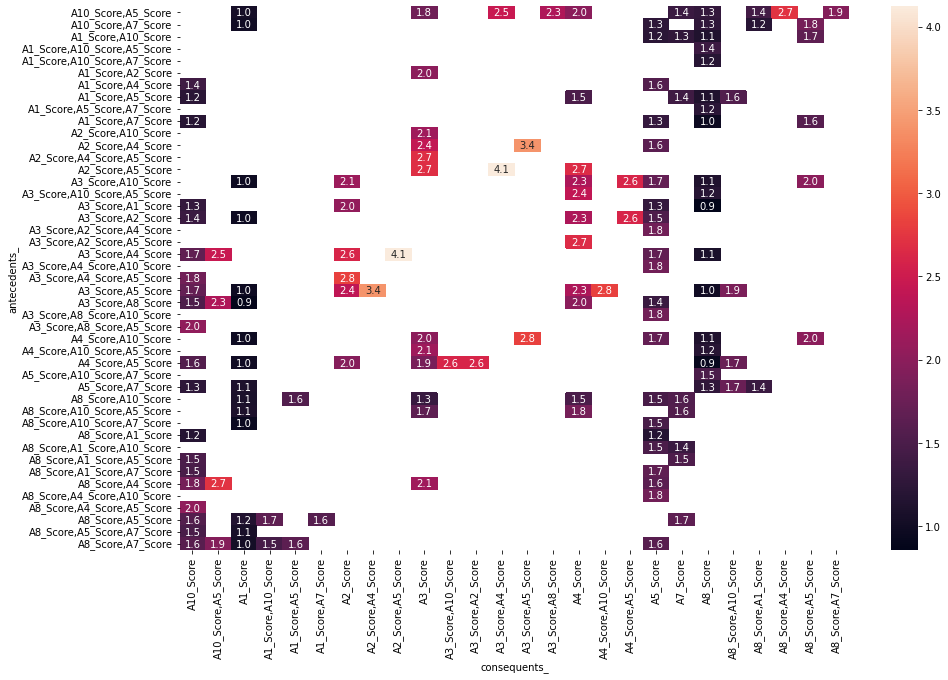

In [156]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [157]:
# Create a dataset for South Asian ethnicity
sasian_df = female_df[(female_df['ethnicity']=='South Asian')]
sasian_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
57,57,1,0,0,0,1,0,0,1,0,...,32,f,South Asian,no,yes,Canada,no,3,Self,NO
69,69,1,1,0,0,0,0,1,1,0,...,29,f,South Asian,no,no,New Zealand,no,5,Self,NO
99,99,0,1,1,0,0,0,0,1,0,...,26,f,South Asian,no,no,India,no,3,Self,NO
151,151,1,1,0,0,1,0,0,0,0,...,32,f,South Asian,no,no,New Zealand,no,4,Self,NO
156,156,0,1,0,0,1,0,0,1,0,...,29,f,South Asian,no,no,Sri Lanka,no,4,Self,NO


In [158]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= sasian_df[predictors]
y= sasian_df[outcome]
# Convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [159]:
# Create a maximal tree
sasianFullTree = DecisionTreeClassifier(random_state=1)
sasianFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [160]:
# Check for accuracy
classificationSummary(valid_Y, sasianFullTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 8


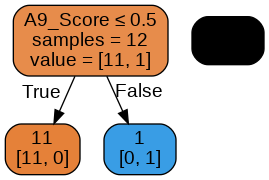

In [161]:
# Plot the tree
plotDecisionTree(sasianFullTree, feature_names=train_X.columns)

In [162]:
# Create parameters to optimize the tree
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [163]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 1 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [164]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

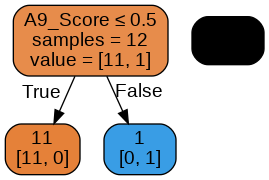

In [165]:
# Create the optimized tree and plot.
sasianClassTree = DecisionTreeClassifier(max_depth=6, 
                                         min_impurity_decrease=0.001, 
                                         min_samples_split=0.01,
                                         random_state=1)
sasianClassTree.fit(train_X, train_Y)
plotDecisionTree(sasianClassTree, feature_names = train_X.columns)

In [166]:
# Check accuracy
classificationSummary(valid_Y, sasianClassTree.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 8


In [167]:
# Create a variable for model prediction
pred_sasiantree = sasianClassTree.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_sasiantree)
tn = cm[0][0]
#fp = cm[0][1]
#fn = cm[1][0]
#tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 0
Total number of false negatives: 3
Total number of false positives: 1
Total number of true negatives: 8


In [168]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [169]:
# Run a grid search to find the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 1 members, which is less than n_splits=3.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [170]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [171]:
# Run a random forest
sasianForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=3, min_impurity_decrease=0.01, min_samples_split=0.05)
sasianForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=3, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [172]:
# Check for variable importance and standard deviation.
importance = sasianForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in sasianForest.estimators_], axis=0)

sasianForest_df = pd.DataFrame({'feature': train_X.columns,
                                'importance': importance,
                                'std': std})
print(sasianForest_df.sort_values('importance', ascending=False))

     feature  importance       std
8   A9_Score    0.399711  0.435647
6   A7_Score    0.220641  0.322541
2   A3_Score    0.202284  0.314878
3   A4_Score    0.079842  0.195680
9  A10_Score    0.039394  0.123713
4   A5_Score    0.035598  0.103124
1   A2_Score    0.021080  0.097675
7   A8_Score    0.001449  0.009950
0   A1_Score    0.000000  0.000000
5   A6_Score    0.000000  0.000000


Text(0.5, 1.0, 'Visualizing Important Features')

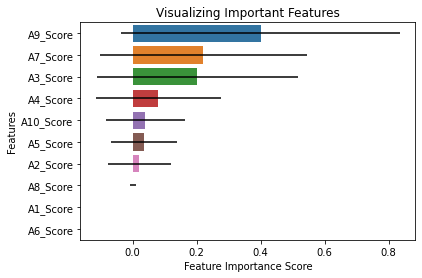

In [173]:
# Plot feature importance
value_plot = sasianForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [174]:
# Check accuracy
classificationSummary(valid_Y, sasianForest.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 8


In [175]:
# Create a variable for model prediciton
pred_sasianforest = sasianForest.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_sasianforest)
tn = cm[0][0]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 0
Total number of false negatives: 3
Total number of false positives: 1
Total number of true negatives: 8


In [176]:
# Create optional hidden layer sizes for neural network
sasianCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [177]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=sasianCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 1 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [178]:
# Check for best optimizer
gridsearch.best_params_

{'hidden_layer_sizes': 1}

In [179]:
# Run a neural network with 1 hidden layer
sasian_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=1, random_state=1)
sasian_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=1, random_state=1,
              solver='lbfgs')

In [182]:
# Check model accuracy
classificationSummary(valid_Y, sasian_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.8750)

       Prediction
Actual 0 1
     0 7 1
     1 0 0


In [183]:
# Run a linear regression
sasian_reg = LinearRegression()
sasian_reg.fit(train_X, train_Y)

LinearRegression()

In [184]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': sasian_reg.coef_[0], 'odds': np.e**sasian_reg.coef_[0]}, index=X.columns))

                   coef      odds
A1_Score  -4.526837e-16  1.000000
A2_Score   6.245005e-16  1.000000
A3_Score  -5.048045e-16  1.000000
A4_Score  -1.769418e-16  1.000000
A5_Score   1.526557e-16  1.000000
A6_Score  -6.505213e-17  1.000000
A7_Score  -4.145989e-16  1.000000
A8_Score  -3.816392e-17  1.000000
A9_Score   1.000000e+00  2.718282
A10_Score  4.649059e-16  1.000000


In [185]:
# Check accuracy
regressionSummary(valid_Y, sasian_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.0000
     Mean Absolute Error (MAE) : 0.0000


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

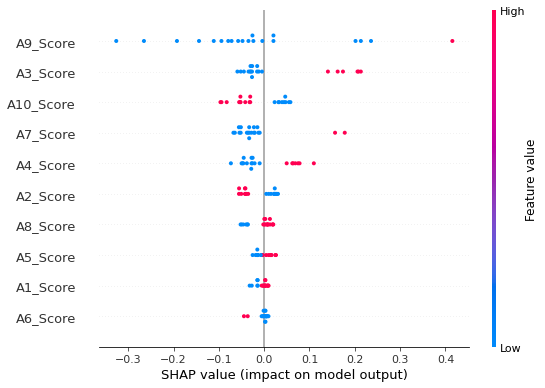

In [186]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(sasian_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [187]:
# Run a logistic regression
sasian_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
sasian_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [188]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': sasian_log_reg.coef_[0], 'odds': np.e**sasian_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score  -0.438452  0.645034
A2_Score  -0.466713  0.627060
A3_Score   0.425723  1.530696
A4_Score   0.215254  1.240177
A5_Score  -0.095514  0.908906
A6_Score  -0.123466  0.883852
A7_Score   0.457638  1.580337
A8_Score  -0.424720  0.653953
A9_Score   0.547442  1.728825
A10_Score -0.565587  0.568027


In [189]:
# Check accuracy
classificationSummary(valid_Y, sasian_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual 0
     0 8


In [190]:
# Create a variable for model prediction and accuracy
pred_sasianlog = sasian_log_reg.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_sasianlog)
tn = cm[0][0]
#fp = cm[0][1]
#fn = cm[1][0]
#tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 0
Total number of false negatives: 3
Total number of false positives: 1
Total number of true negatives: 8


In [191]:
# Create a dataset using _Score variables and ID. Set ID as the index.
sasian_scores = sasian_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
sasian_scores.set_index('ID', inplace=True)
sasian_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
57,1,0,0,0,1,0,0,1,0,0
69,1,1,0,0,0,0,1,1,0,1
99,0,1,1,0,0,0,0,1,0,0
151,1,1,0,0,1,0,0,0,0,1
156,0,1,0,0,1,0,0,1,0,1


In [192]:
# Check for frequent itemsets using apriori.
questionsets = apriori(sasian_scores, min_support=.15, use_colnames=True) # Set support to 15% frequency.
questionsets.head()

,support,itemsets
0,0.70,(A1_Score)
1,0.45,(A2_Score)
2,0.30,(A3_Score)
3,0.35,(A4_Score)
4,0.45,(A5_Score)


In [193]:
# Check for relations between _Score variables using association rules.
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with a min threshold of 50%.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
32,(A4_Score),"(A3_Score, A1_Score)",0.35,0.25,0.2,0.571429,2.285714,0.1125,1.750000
28,"(A3_Score, A1_Score)",(A4_Score),0.25,0.35,0.2,0.800000,2.285714,0.1125,3.250000
31,(A3_Score),"(A1_Score, A4_Score)",0.30,0.35,0.2,0.666667,1.904762,0.0950,1.950000
30,"(A1_Score, A4_Score)",(A3_Score),0.35,0.30,0.2,0.571429,1.904762,0.0950,1.633333
13,(A3_Score),(A4_Score),0.30,0.35,0.2,0.666667,1.904762,0.0950,1.950000


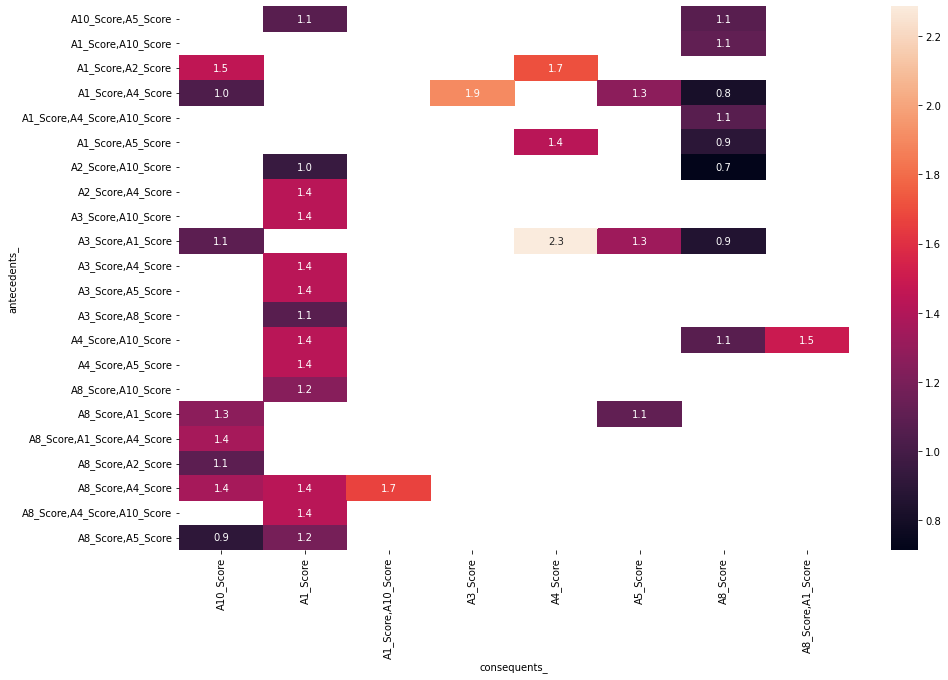

In [194]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [195]:
# Replace value 'Middle Eastern ' with 'Middle Eastern'
female_df['ethnicity'] = female_df['ethnicity'].replace(['Middle Eastern '], 'Middle Eastern')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [196]:
# Create dataset for Middle Eastern ethnicity
eastern_df = female_df[(female_df['ethnicity']=='Middle Eastern')]
eastern_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
11,11,0,1,0,1,1,1,1,0,0,...,18,f,Middle Eastern,no,no,Burundi,no,6,Parent,NO
18,18,0,0,1,0,1,1,0,0,0,...,35,f,Middle Eastern,no,yes,United Arab Emirates,no,3,Self,NO
42,42,0,0,1,1,0,0,0,0,0,...,34,f,Middle Eastern,no,yes,Egypt,no,3,Self,NO
82,82,0,0,1,0,1,0,0,1,0,...,42,f,Middle Eastern,no,no,Jordan,no,4,Self,NO
84,84,1,0,0,0,0,0,0,1,0,...,27,f,Middle Eastern,no,no,United States,no,3,Self,NO


In [197]:
# Split the dataset with Class/ASD as the target variable.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= eastern_df[predictors]
y= eastern_df[outcome]
# convert categorical variables to dummies
X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [198]:
# Create a maximal tree
easternFullTree = DecisionTreeClassifier(random_state=1)
easternFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [199]:
# Check for accuracy
classificationSummary(valid_Y, easternFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8125)

       Prediction
Actual  0  1
     0 13  3
     1  0  0


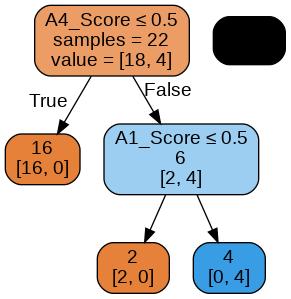

In [200]:
# plot the tree
plotDecisionTree(easternFullTree, feature_names=train_X.columns)

In [201]:
# Create decision tree parameters
param_grid = {
    'max_depth':[3, 5, 6, 7, 9],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [202]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 4 members, which is less than n_splits=5.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 7, 9],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [203]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

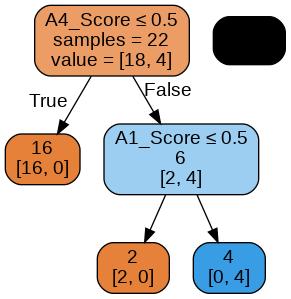

In [204]:
# Plot the optimized tree
easternClassTree = DecisionTreeClassifier(max_depth=7, 
                                          min_impurity_decrease=0.001, 
                                          min_samples_split=0.01,
                                          random_state=1)
easternClassTree.fit(train_X, train_Y)
plotDecisionTree(easternClassTree, feature_names = train_X.columns)

In [205]:
# Check accuracy
classificationSummary(valid_Y, easternClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8125)

       Prediction
Actual  0  1
     0 13  3
     1  0  0


In [206]:
# Create variable for model prediction
pred_easterntree = easternClassTree.predict(valid_X)

# Run a confusion matrix and print true negatives, false positives, false negatives, and true positives.
cm = confusion_matrix(valid_Y, pred_easterntree)
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp = cm[1][1]

print("\nTotal number of true positives:", tp)
print("Total number of false negatives:",fn)
print("Total number of false positives:",fp)
print("Total number of true negatives:",tn)


Total number of true positives: 0
Total number of false negatives: 0
Total number of false positives: 3
Total number of true negatives: 13


In [207]:
# Set random forest parameters 
param_grid = {
    'max_depth':[3, 5, 6, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [208]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 6, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [209]:
# Check best parameters
gridsearch.best_params_

{'max_depth': 3,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 100}

In [210]:
# Run a random forest
easternForest = RandomForestClassifier(random_state=1, n_estimators=100, max_depth=100, min_impurity_decrease=0.01, min_samples_split=0.05)
easternForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=100, min_impurity_decrease=0.01,
                       min_samples_split=0.05, random_state=1)

In [211]:
# Check variable importance and standard deviation
importance = easternForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in easternForest.estimators_], axis=0)

easternForest_df = pd.DataFrame({'feature': train_X.columns,
                                 'importance': importance,
                                 'std': std})
print(easternForest_df.sort_values('importance', ascending=False))

     feature  importance       std
3   A4_Score    0.245795  0.335497
5   A6_Score    0.143140  0.252164
0   A1_Score    0.123708  0.190009
4   A5_Score    0.105881  0.226572
8   A9_Score    0.098781  0.232090
6   A7_Score    0.080330  0.174127
7   A8_Score    0.069153  0.141821
2   A3_Score    0.054588  0.158233
1   A2_Score    0.049117  0.127720
9  A10_Score    0.029508  0.073131


Text(0.5, 1.0, 'Visualizing Important Features')

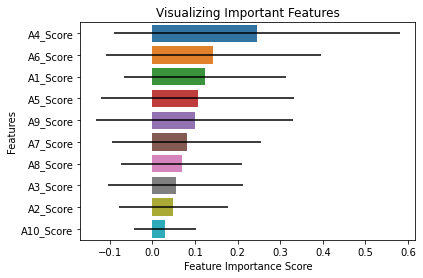

In [212]:
# Plot feature importance
value_plot = easternForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [213]:
# Check accuracy
classificationSummary(valid_Y, easternForest.predict(valid_X))

Confusion Matrix (Accuracy 1.0000)

       Prediction
Actual  0
     0 16


In [214]:
# Create optional hidden layer sizes for neural network
easternCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [215]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=easternCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

The least populated class in y has only 4 members, which is less than n_splits=5.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [216]:
# Find optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 5}

In [217]:
# Run a neural network with 5 hidden layers
eastern_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=5, random_state=1)
eastern_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=5, random_state=1,
              solver='lbfgs')

In [220]:
# Check model accuracy
classificationSummary(valid_Y, eastern_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9375)

       Prediction
Actual  0  1
     0 15  1
     1  0  0


In [221]:
# Run a linear regression
eastern_reg = LinearRegression()
eastern_reg.fit(train_X, train_Y)

LinearRegression()

In [222]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': eastern_reg.coef_[0], 'odds': np.e**eastern_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.301275  1.351581
A2_Score   0.018381  1.018551
A3_Score   0.264117  1.302281
A4_Score   0.589905  1.803816
A5_Score  -0.183063  0.832716
A6_Score   0.187723  1.206499
A7_Score   0.121175  1.128823
A8_Score   0.138546  1.148603
A9_Score   0.173051  1.188927
A10_Score -0.059835  0.941920


In [223]:
# Check accuracy
regressionSummary(valid_Y, eastern_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.3178
Root Mean Squared Error (RMSE) : 0.4432
     Mean Absolute Error (MAE) : 0.3832


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

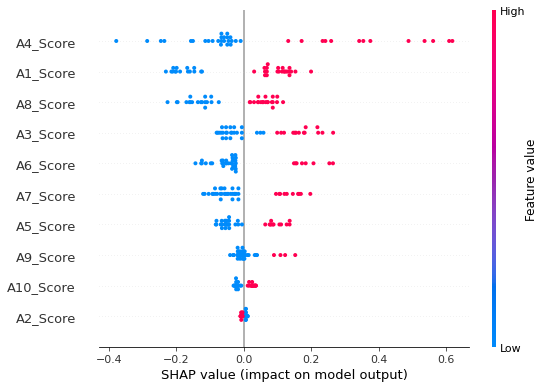

In [224]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(eastern_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [225]:
# Run a logistic Regression
eastern_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
eastern_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [226]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': eastern_log_reg.coef_[0], 'odds': np.e**eastern_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.146552  1.157835
A2_Score  -0.587248  0.555855
A3_Score   0.199677  1.221008
A4_Score   0.950982  2.588250
A5_Score   0.424133  1.528265
A6_Score   0.477727  1.612405
A7_Score   0.350436  1.419686
A8_Score   0.051084  1.052412
A9_Score   0.137483  1.147382
A10_Score -0.036840  0.963831


In [227]:
# Check accuracy
classificationSummary(valid_Y, eastern_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9375)

       Prediction
Actual  0  1
     0 15  1
     1  0  0


In [228]:
# Create dataset with _Score variables and ID. Set ID as the index
eastern_scores = eastern_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
eastern_scores.set_index('ID', inplace=True)
eastern_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
11,0,1,0,1,1,1,1,0,0,1
18,0,0,1,0,1,1,0,0,0,0
42,0,0,1,1,0,0,0,0,0,1
82,0,0,1,0,1,0,0,1,0,1
84,1,0,0,0,0,0,0,1,0,1


In [229]:
# Check for frequent itemsets using apriori. 
questionsets = apriori(eastern_scores, min_support=.12, use_colnames=True) # Set min frequency to 12%.
questionsets.head()

,support,itemsets
0,0.605263,(A1_Score)
1,0.447368,(A2_Score)
2,0.368421,(A3_Score)
3,0.342105,(A4_Score)
4,0.315789,(A5_Score)


In [230]:
# Check for relations between _Score variables using association rules.
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as metric and set threshold to 50%
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
75,"(A1_Score, A10_Score)","(A8_Score, A5_Score)",0.236842,0.184211,0.131579,0.555556,3.015873,0.087950,1.835526
73,"(A8_Score, A5_Score)","(A1_Score, A10_Score)",0.184211,0.236842,0.131579,0.714286,3.015873,0.087950,2.671053
74,"(A1_Score, A5_Score)","(A8_Score, A10_Score)",0.184211,0.289474,0.131579,0.714286,2.467532,0.078255,2.486842
60,"(A10_Score, A5_Score)",(A7_Score),0.210526,0.263158,0.131579,0.625000,2.375000,0.076177,1.964912
56,"(A4_Score, A10_Score)",(A7_Score),0.210526,0.263158,0.131579,0.625000,2.375000,0.076177,1.964912


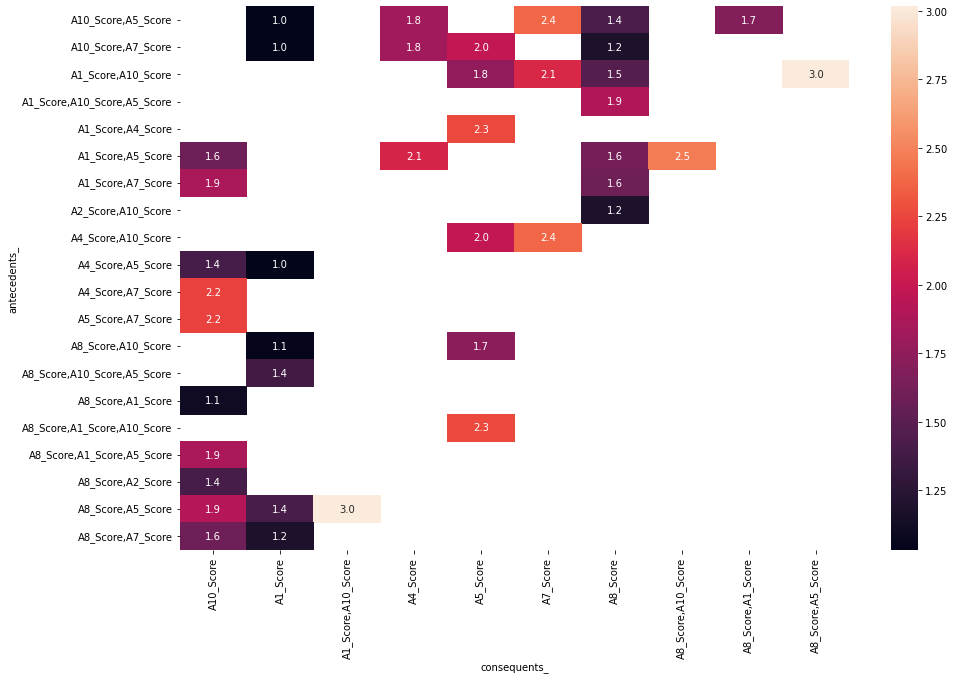

In [231]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [232]:
female_df['ethnicity'].value_counts() # Group 'Others' has the second most number of records. Will require further investigation if found significant

White             124
Others             63
Asian              51
Middle Eastern     38
Black              23
South Asian        20
Latino              8
Pasifika            5
Hispanic            2
Turkish             2
Name: ethnicity, dtype: int64

In [233]:
others_df = female_df[(female_df['ethnicity']=='Others')]
others_df.head()

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,age,gender,ethnicity,jaundice,autism_in_family,country_of_res,used_app_before,result,relation,Class/ASD
4,4,1,0,0,0,0,0,0,1,0,...,40,f,Others,no,no,Egypt,no,2,Others,NO
12,12,0,1,1,1,1,1,0,0,1,...,17,f,Others,no,no,Bahamas,no,6,Others,NO
14,14,1,0,0,0,0,0,1,1,0,...,17,f,Others,no,no,Argentina,no,4,Others,NO
25,25,0,1,1,0,0,0,0,1,0,...,24,f,Others,yes,no,Afghanistan,no,3,Others,NO
32,32,1,1,0,0,0,0,1,0,0,...,55,f,Others,no,no,New Zealand,no,4,Self,NO


In [234]:
# Split the dataset with Class/ASD as the target variable, using only _Scores as perdictors.
predictors = ['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score']
outcome = 'Class/ASD'

x= others_df[predictors]
y= others_df[outcome]

X = x
Y = pd.get_dummies(y, drop_first=True)

train_X, valid_X, train_Y, valid_Y = train_test_split(X, Y, test_size=0.4, random_state=1)

In [235]:
# Create a maximal tree
othersFullTree = DecisionTreeClassifier(random_state=1)
othersFullTree.fit(train_X, train_Y)

DecisionTreeClassifier(random_state=1)

In [236]:
# Check model accuracy
classificationSummary(valid_Y, othersFullTree.predict(valid_X))

Confusion Matrix (Accuracy 0.9231)

       Prediction
Actual  0  1
     0 21  2
     1  0  3


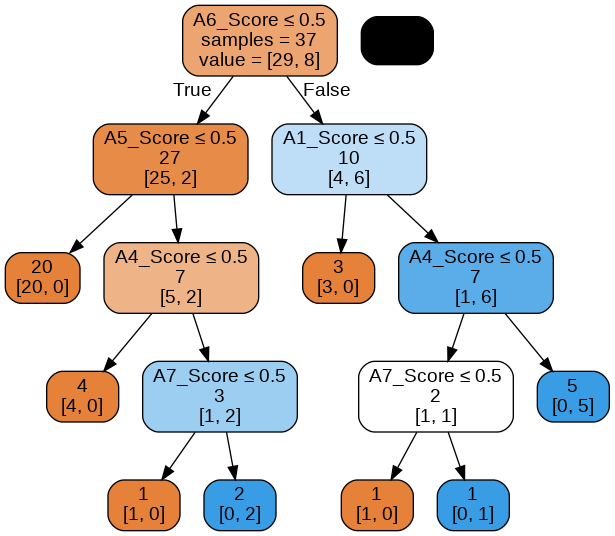

In [237]:
# Plot the maximal tree
plotDecisionTree(othersFullTree, feature_names=train_X.columns)

In [238]:
# Create decision tree parameters
param_grid = {
    'max_depth':[3, 4, 5],
    'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001],
    'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005, 0.0001]
} 

In [239]:
# Run a grid search to find optimal parameters
gridsearch = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=5, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5],
                         'min_impurity_decrease': [0.02, 0.01, 0.001, 0.005,
                                                   0.0001],
                         'min_samples_split': [0.07, 0.05, 0.01, 0.005, 0.001]})

In [240]:
# Check for best parameters
gridsearch.best_params_

{'max_depth': 3, 'min_impurity_decrease': 0.02, 'min_samples_split': 0.07}

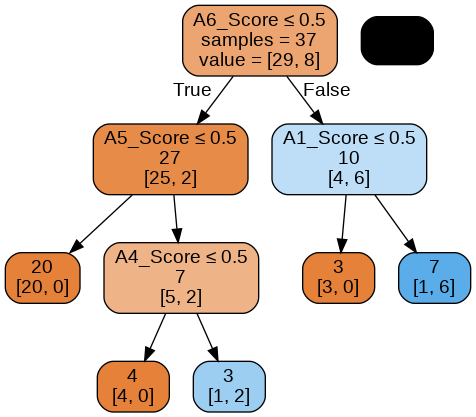

In [241]:
# Plot the optimized tree
othersClassTree = DecisionTreeClassifier(max_depth=3, 
                                         min_impurity_decrease=0.02, 
                                         min_samples_split=0.07,
                                         random_state=1)
othersClassTree.fit(train_X, train_Y)
plotDecisionTree(othersClassTree, feature_names = train_X.columns)

In [242]:
# Check model accuracy
classificationSummary(valid_Y, othersClassTree.predict(valid_X))

Confusion Matrix (Accuracy 0.8846)

       Prediction
Actual  0  1
     0 20  3
     1  0  3


In [243]:
# Set random forest parameters 
param_grid = {
    'max_depth':[6, 7, 8],
    'min_samples_split': [0.05, 0.01, 0.001],
    'min_impurity_decrease': [0.01, 0.001, 0.005],
    'n_estimators':[100, 200, 300]
} 

In [244]:
# Perform a grid search for the best parameters
gridsearch = GridSearchCV(RandomForestClassifier(random_state=1), param_grid, cv=3, n_jobs=-1)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8],
                         'min_impurity_decrease': [0.01, 0.001, 0.005],
                         'min_samples_split': [0.05, 0.01, 0.001],
                         'n_estimators': [100, 200, 300]})

In [245]:
# Check for best paramters
gridsearch.best_params_

{'max_depth': 6,
 'min_impurity_decrease': 0.01,
 'min_samples_split': 0.05,
 'n_estimators': 200}

In [246]:
# Run a random forest
othersForest = RandomForestClassifier(random_state=1, n_estimators=200, max_depth=6, min_impurity_decrease=0.01, min_samples_split=0.05)
othersForest.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomForestClassifier(max_depth=6, min_impurity_decrease=0.01,
                       min_samples_split=0.05, n_estimators=200,
                       random_state=1)

In [247]:
# Check feature importance and standard deviation
importance = othersForest.feature_importances_
std = np.std([tree.feature_importances_ for tree in othersForest.estimators_], axis=0)

othersForest_df = pd.DataFrame({'feature': train_X.columns,
                               'importance': importance,
                               'std': std})
print(othersForest_df.sort_values('importance', ascending=False))

     feature  importance       std
5   A6_Score    0.184331  0.228697
2   A3_Score    0.149925  0.195401
0   A1_Score    0.141121  0.160155
9  A10_Score    0.130710  0.167918
3   A4_Score    0.115434  0.171144
6   A7_Score    0.075438  0.121132
8   A9_Score    0.072099  0.141851
4   A5_Score    0.066481  0.131708
7   A8_Score    0.038319  0.100929
1   A2_Score    0.026143  0.063714


Text(0.5, 1.0, 'Visualizing Important Features')

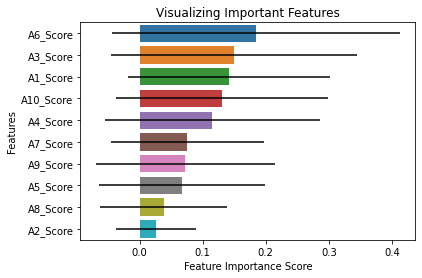

In [248]:
# Plot feature importance
value_plot = othersForest_df.sort_values('importance', ascending = False)
sns.barplot(x = value_plot['importance'], y = value_plot['feature'], xerr = value_plot['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [249]:
# Check accuracy
classificationSummary(valid_Y, othersForest.predict(valid_X))

Confusion Matrix (Accuracy 0.9615)

       Prediction
Actual  0  1
     0 23  0
     1  1  2


In [250]:
# Create optional hidden layer sizes for neural network
othersCLF_param = {'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]}

In [251]:
# Run a gridsearch to find the best hidden layer size
gridsearch= GridSearchCV(MLPClassifier(activation='logistic', solver='lbfgs', random_state=1, max_iter=500),
                         param_grid=othersCLF_param, cv=5, n_jobs=-1, return_train_score=True)
gridsearch.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=MLPClassifier(activation='logistic', max_iter=500,
                                     random_state=1, solver='lbfgs'),
             n_jobs=-1,
             param_grid={'hidden_layer_sizes': [1, 2, 3, 4, 5, 6, 7, 8]},
             return_train_score=True)

In [252]:
# Check optimal hidden layer size
gridsearch.best_params_

{'hidden_layer_sizes': 7}

In [253]:
# Run a neural network with 7 hidden layers
others_clf = MLPClassifier(activation = 'logistic', solver='lbfgs', hidden_layer_sizes=7, random_state=1)
others_clf.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


MLPClassifier(activation='logistic', hidden_layer_sizes=7, random_state=1,
              solver='lbfgs')

In [254]:
# Check model accuracy
classificationSummary(valid_Y, others_clf.predict(valid_X))

Confusion Matrix (Accuracy 0.9615)

       Prediction
Actual  0  1
     0 23  0
     1  1  2


<Figure size 720x720 with 0 Axes>

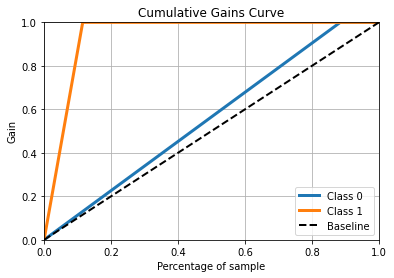

In [255]:
# Create a variable for model prediction probabilities
others_clf_pred = others_clf.predict_proba(valid_X)

# Plot the cumulative gains chart
plt.figure(figsize=(10,10))
skplt.metrics.plot_cumulative_gain(valid_Y, others_clf_pred)
plt.show()

In [256]:
# Run a linear regression
others_reg = LinearRegression()
others_reg.fit(train_X, train_Y)

LinearRegression()

In [257]:
# Check variable coefficients and ods ratio
print(pd.DataFrame({'coef': others_reg.coef_[0], 'odds': np.e**others_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.197999  1.218962
A2_Score   0.053099  1.054534
A3_Score   0.211609  1.235664
A4_Score   0.142663  1.153341
A5_Score   0.056477  1.058102
A6_Score   0.238977  1.269950
A7_Score   0.078144  1.081279
A8_Score   0.085709  1.089489
A9_Score  -0.003016  0.996989
A10_Score  0.188687  1.207663


In [258]:
# Check accuracy
regressionSummary(valid_Y, others_reg.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0565
Root Mean Squared Error (RMSE) : 0.2406
     Mean Absolute Error (MAE) : 0.1878


Estimating transforms:   0%|          | 0/1000 [00:00<?, ?it/s]

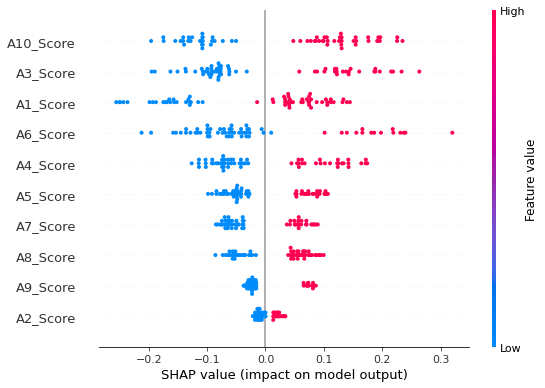

In [259]:
# Use shap to vizualize feature value and impact on the target
explainer = shap.Explainer(others_reg, masker=shap.maskers.Impute(data= train_X),
                           feature_names= train_X.columns, algorithm="linear")
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

In [260]:
# Run a logistic regression
others_log_reg = LogisticRegression(solver='liblinear', C=1, random_state=1)
others_log_reg.fit(train_X, train_Y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


LogisticRegression(C=1, random_state=1, solver='liblinear')

In [261]:
# Check variable coefficients and odds ratio
print(pd.DataFrame({'coef': others_log_reg.coef_[0], 'odds': np.e**others_log_reg.coef_[0]}, index=X.columns))

               coef      odds
A1_Score   0.272381  1.313088
A2_Score  -0.282600  0.753821
A3_Score   0.613614  1.847095
A4_Score   0.303012  1.353931
A5_Score   0.223514  1.250463
A6_Score   0.862661  2.369456
A7_Score   0.191211  1.210714
A8_Score   0.001703  1.001704
A9_Score   0.081361  1.084762
A10_Score  0.593402  1.810135


In [262]:
# Check accuracy
classificationSummary(valid_Y, others_log_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9615)

       Prediction
Actual  0  1
     0 23  0
     1  1  2


In [263]:
# Create a dataset using _Score variables and ID. Set ID as index.
others_scores = others_df[['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'ID']]
others_scores.set_index('ID', inplace=True)
others_scores.head()

,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score
ID,,,,,,,,,,
4,1,0,0,0,0,0,0,1,0,0
12,0,1,1,1,1,1,0,0,1,0
14,1,0,0,0,0,0,1,1,0,1
25,0,1,1,0,0,0,0,1,0,0
32,1,1,0,0,0,0,1,0,0,1


In [264]:
# Check for frequent itemsets using apriori
questionsets = apriori(others_scores, min_support=.15, use_colnames=True) # Set minimum support to 15%.
questionsets.head()

,support,itemsets
0,0.619048,(A1_Score)
1,0.349206,(A2_Score)
2,0.380952,(A3_Score)
3,0.412698,(A4_Score)
4,0.380952,(A5_Score)


In [265]:
# Check for relations between _Scores using association rules
rules = association_rules(questionsets, metric='confidence', min_threshold=0.5) # Use confidence as the metric with 50% minimum threshold.
rules.sort_values(by=['lift'], ascending=False).head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
76,"(A3_Score, A4_Score)",(A6_Score),0.269841,0.238095,0.158730,0.588235,2.470588,0.094482,1.850340
79,(A6_Score),"(A3_Score, A4_Score)",0.238095,0.269841,0.158730,0.666667,2.470588,0.094482,2.190476
72,"(A3_Score, A5_Score)",(A4_Score),0.190476,0.412698,0.190476,1.000000,2.423077,0.111867,inf
77,"(A3_Score, A6_Score)",(A4_Score),0.158730,0.412698,0.158730,1.000000,2.423077,0.093222,inf
78,"(A4_Score, A6_Score)",(A3_Score),0.190476,0.380952,0.158730,0.833333,2.187500,0.086168,3.714286


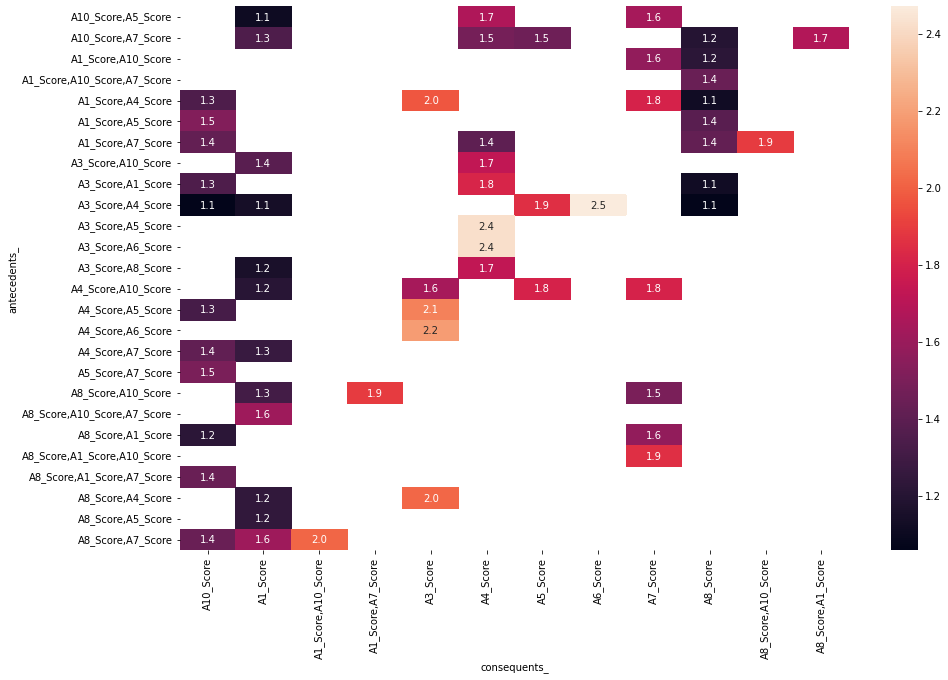

In [266]:
# Create a heatmap to plot association between _Scores
rules['lhs items'] = rules['antecedents'].apply(lambda x:len(x) )
rules[rules['lhs items']>1].sort_values('lift', ascending=False).head()

# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')


# Replace frozen sets with strings
rules['antecedents_'] = rules['antecedents'].apply(lambda a: ','.join(list(a)))
rules['consequents_'] = rules['consequents'].apply(lambda a: ','.join(list(a)))

# Transform the DataFrame of rules into a matrix using the lift metric
pivot = rules[rules['lhs items']>1].pivot(index = 'antecedents_', 
                    columns = 'consequents_', values= 'lift')

# Generate a heatmap with annotations on and the colorbar off
plt.figure(figsize = (15, 10))
sns.heatmap(pivot, annot = True, fmt='.1f')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()